# LangGraph with Stock Data Analysis: Answers

This notebook demonstrates how to use `langgraph` and `langchain` to create a workflow for retrieving and analyzing stock data using the `yfinance` library and OpenAI's GPT-3.5-turbo model.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1fiaWf3iirzyDb8QypWDSZWN1xWPTuJVL?usp=sharing)

## Installation

First, we need to install the necessary packages:

In [ ]:
!pip install -q langgraph langchain langchain_openai langchainhub yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip freeze | grep "lang\|openai\|yfinance"

google-ai-generativelanguage==0.6.4
google-cloud-language==2.13.3
langchain==0.2.1
langchain-core==0.2.2
langchain-openai==0.1.8
langchain-text-splitters==0.2.0
langchainhub==0.1.17
langcodes==3.4.0
langgraph==0.0.57
langsmith==0.1.63
language_data==1.2.0
libclang==18.1.1
openai==1.30.5
yfinance==0.2.40


In [ ]:
from google.colab import userdata
import os

# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

## Tool Definitions
We define tools for retrieving current stock information, historical data, and corporate actions using the `yfinance` library.

In [ ]:
# Documentation
# https://pypi.org/project/yfinance/

In [ ]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage
import yfinance as yf

@tool("get_current_info")
def get_current_info(name):
    """
    Retrieves the current information of a specified stock.
    If user asks about the current stock price - this is the tool to be called

    Args:
        name (str): The ticker symbol of the stock (e.g., 'AAPL' for Apple Inc.).

    Returns:
        dict: A dictionary containing various details about the stock, including
              company information, market data, financials, and more.
    """
    stock = yf.Ticker(name)
    return stock.info

@tool("get_history")
def get_history(name, period="1mo"):
    """
    Retrieves the historical market data for a specified stock over a given period.

    Args:
        name (str): The ticker symbol of the stock (e.g., 'AAPL' for Apple Inc.).
        period (str, optional): The period over which to retrieve historical data.
                                Default is '1mo'. Other options include '1d', '5d', '1mo',
                                '3mo', '6mo', '1y', '2y', '5y', '10y', and 'max'.

    Returns:
        pandas.DataFrame: A DataFrame containing historical market data for the specified stock,
                          including columns such as 'Open', 'High', 'Low', 'Close', 'Volume', etc.
    """
    stock = yf.Ticker(name)
    return stock.history(period=period)

@tool("get_actions")
def get_actions(name):
    """
    Retrieves corporate actions (e.g., dividends, splits) for a specified stock.

    Args:
        name (str): The ticker symbol of the stock (e.g., 'AAPL' for Apple Inc.).

    Returns:
        pandas.DataFrame: A DataFrame containing corporate actions for the specified stock,
                          including columns such as 'Date', 'Dividends', 'Stock Splits', etc.
    """
    stock = yf.Ticker(name)
    return stock.actions

## Creating the Agent
We create an agent using `langchain` to handle stock-related queries.

In [ ]:
# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Get the prompt to use (default)
prompt = hub.pull("hwchase17/openai-functions-agent")

tools = [get_current_info, get_history, get_actions]
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

## Defining the Workflow
We define the workflow using langgraph.

### Define the Agent
We define the agent and the function to execute tools.

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.agents import AgentFinish

# Define the agent
agent = RunnablePassthrough.assign(
    agent_outcome = agent_runnable
)

# Define the function to execute tools
def execute_tools(data):
    agent_action = data.pop('agent_outcome')
    tool_to_use = {t.name: t for t in tools}[agent_action.tool]
    observation = tool_to_use.invoke(agent_action.tool_input)
    data['intermediate_steps'].append((agent_action, observation))
    return data

# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    if isinstance(data['agent_outcome'], AgentFinish):
        return "exit"
    else:
        return "continue"

### Creating the Workflow Graph
We create the workflow graph and compile it into a LangChain Runnable.

In [ ]:
from langgraph.graph import END, Graph

workflow = Graph()

workflow.add_node("agent", agent)
workflow.add_node("tools_executor", execute_tools)

# Set the entrypoint as `agent`
workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools_executor",
        "exit": END
    }
)
workflow.add_edge('tools_executor', 'agent')



# This compiles it into a LangChain Runnable,
# meaning we can use it as you would any other runnable
graph = workflow.compile()

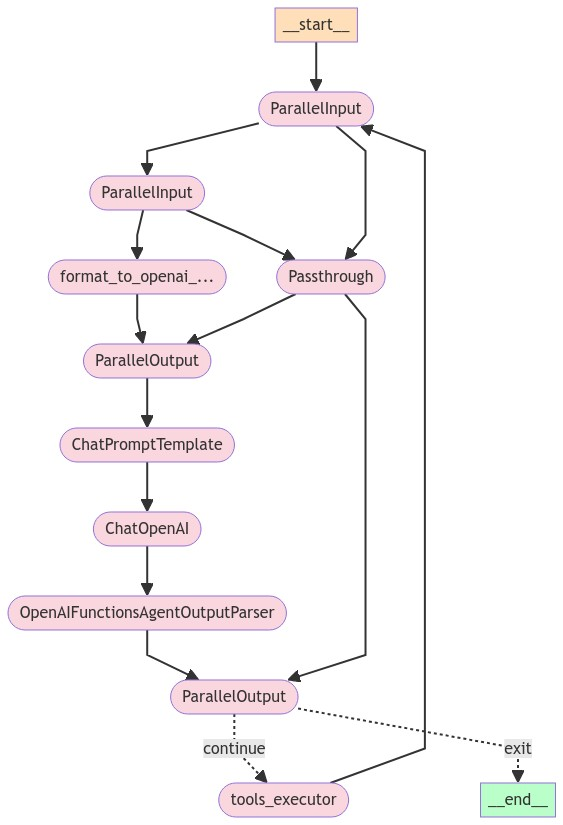

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Running the Workflow
We run the workflow with sample queries and compare the results with baseline answers.

In [ ]:
query = "What is the latest stock price for AAPL, MSFT, and GOOG?"

In [ ]:
inputs = {"input": query,"intermediate_steps": [],"recursion_limit": 150}

for s in graph.stream(inputs):
    try:
        print(s['agent']['input'])
        print(s['agent']['agent_outcome'])
        print("----")
    except Exception as e:
        print(e)

What is the latest stock price for AAPL, MSFT, and GOOG?
tool='get_current_info' tool_input={'name': 'AAPL'} log="\nInvoking: `get_current_info` with `{'name': 'AAPL'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"name":"AAPL"}', 'name': 'get_current_info'}}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 422, 'total_tokens': 438}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-10862681-7367-47bb-a2ab-d58df9d69dc9-0', usage_metadata={'input_tokens': 422, 'output_tokens': 16, 'total_tokens': 438})]
----
'agent'
What is the latest stock price for AAPL, MSFT, and GOOG?
tool='get_current_info' tool_input={'name': 'MSFT'} log="\nInvoking: `get_current_info` with `{'name': 'MSFT'}`\n\n\n" message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"name":"MSFT"}', 'name': 'get_current_info'}}, response_metadata={'t

In [ ]:
# baseline answer
companies = 'msft aapl goog'
tickers = yf.Tickers(companies)
for x in companies.split(" "):
    print(x, tickers.tickers[x.upper()].info['currentPrice'])

msft 429.17
aapl 190.29
goog 177.4


In [ ]:
result = graph.invoke({"input": query, "intermediate_steps": []})
output = result['agent_outcome'].return_values["output"]
print(output)

The latest stock prices for AAPL, MSFT, and GOOG are as follows:
- Apple Inc. (AAPL): $190.29
- Microsoft Corporation (MSFT): $429.17
- Alphabet Inc. (GOOG): $177.40

If you need more information or details, feel free to ask!


In [ ]:
query = "What was the highest closing price of Apple stock in the last 4 weeks?"

In [ ]:
result = graph.invoke({"input": query, "intermediate_steps": []})
output = result['agent_outcome'].return_values["output"]
print(output)

The highest closing price of Apple stock in the last 4 weeks was $192.35.


In [ ]:
# baseline answer
tickers.tickers['AAPL'].history(period="3mo").iloc[-35:].sort_values(['Close'], ascending=False).head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-21 00:00:00-04:00,191.089996,192.729996,190.919998,192.350006,42309400,0.0,0.0
2024-05-20 00:00:00-04:00,189.330002,191.919998,189.009995,191.039993,44361300,0.0,0.0
2024-05-22 00:00:00-04:00,192.270004,192.820007,190.270004,190.899994,34648500,0.0,0.0


In [ ]:
query = "How many stock splits google had in the last 10 years?"

In [ ]:
result = graph.invoke({"input": query, "intermediate_steps": []})
output = result['agent_outcome'].return_values["output"]
print(output)

Google (GOOGL) had 2 stock splits in the last 10 years. The stock splits occurred on the following dates:
1. April 3, 2014 - 1.998 stock split
2. July 18, 2022 - 20.000 stock split


In [ ]:
# baseline answer
tickers.tickers['GOOG'].actions

,Dividends,Stock Splits
Date,,
2014-03-27 00:00:00-04:00,0.0,2.002000
2015-04-27 00:00:00-04:00,0.0,1.002746
2022-07-18 00:00:00-04:00,0.0,20.000000
